In [1]:
import pathlib
import sys

ROOT = pathlib.Path(".").absolute().parent.parent
sys.path.append(str(ROOT))

In [2]:
from utils.metrics import (
    plot_classification_report,
    print_scores,
    plot_tsne_features
)
from pycave.bayes.gmm.estimator import GaussianMixture
from utils.dataset import get_numpy_dataset_from_dataloader
import os
from datasets.SPCUP22DataModule import SPCUP22DataModule
from features.audio import MFCC, CQCC
from utils.config import load_config_file
from torchvision.transforms import Compose
from tqdm import tqdm
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

/home/iubnlp/anaconda3/envs/spcup/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [4]:
train_config = load_config_file(ROOT.joinpath("config", "train_params.yaml"))[
    "gmm"
]

In [5]:
n_mfcc = train_config["features"]["n_mfcc"]
hop_length = train_config["features"]["hop_length"]

In [6]:
batch_size = 200
mfcc_extractor = MFCC(n_mfcc=n_mfcc, hop_length=hop_length)
transforms = Compose([mfcc_extractor])

In [7]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_unseen_in_training_data=True,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...


In [8]:
data_module.num_test_samples

1200

In [9]:
test_dataloader = data_module.test_dataloader()
X, true_labels = get_numpy_dataset_from_dataloader(test_dataloader, batch_size, return_true_labels=True)

100%|██████████| 6/6 [00:47<00:00,  7.92s/it]


/home/iubnlp/anaconda3/envs/spcup/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

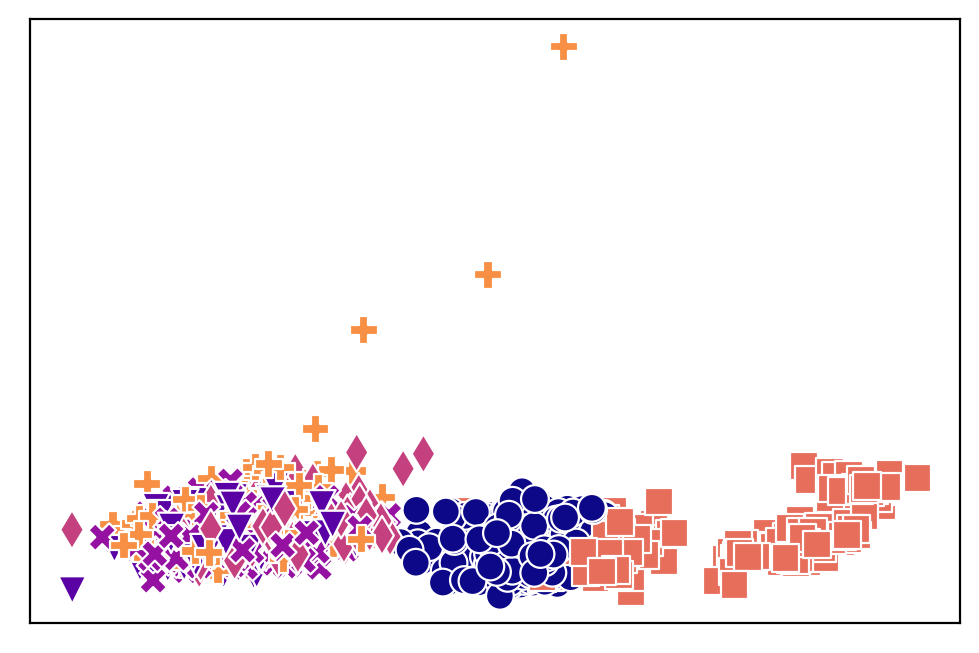

In [10]:
fig, ax = plot_tsne_features(X, true_labels, "")
fig.savefig(
    ROOT.joinpath("results", "mfcc_no_aug.eps"),
    format="eps",
    bbox_inches="tight",
)

In [9]:
unseen_no_aug_estimator = GaussianMixture.load(
    "/home/iubnlp/spcup22/SPCUP2022/checkpoints/gmm/unseen_no_aug"
)

In [22]:
predicted_probabilities = unseen_no_aug_estimator.predict_proba(X).detach().numpy()
predicted_labels = np.argmax(predicted_probabilities, axis=1)

Predicting: 100%|██████████| 5/5 [00:00<00:00, 93.79it/s]


In [26]:
print_scores(true_labels, predicted_labels)


    F1 Score: 0.25
    Accuracy: 0.25
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

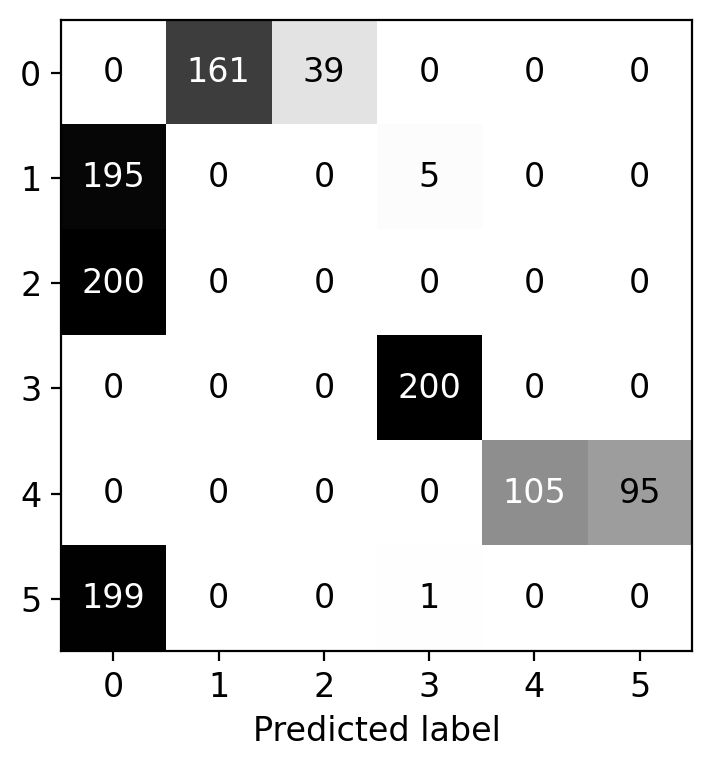

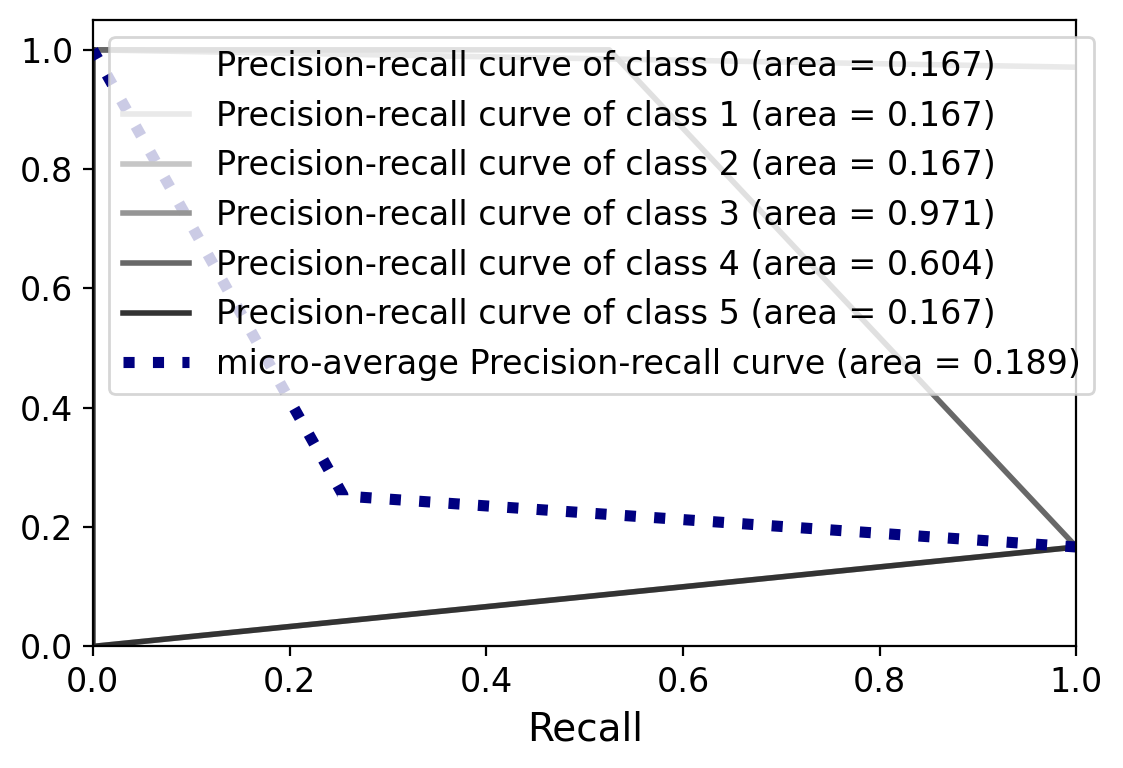

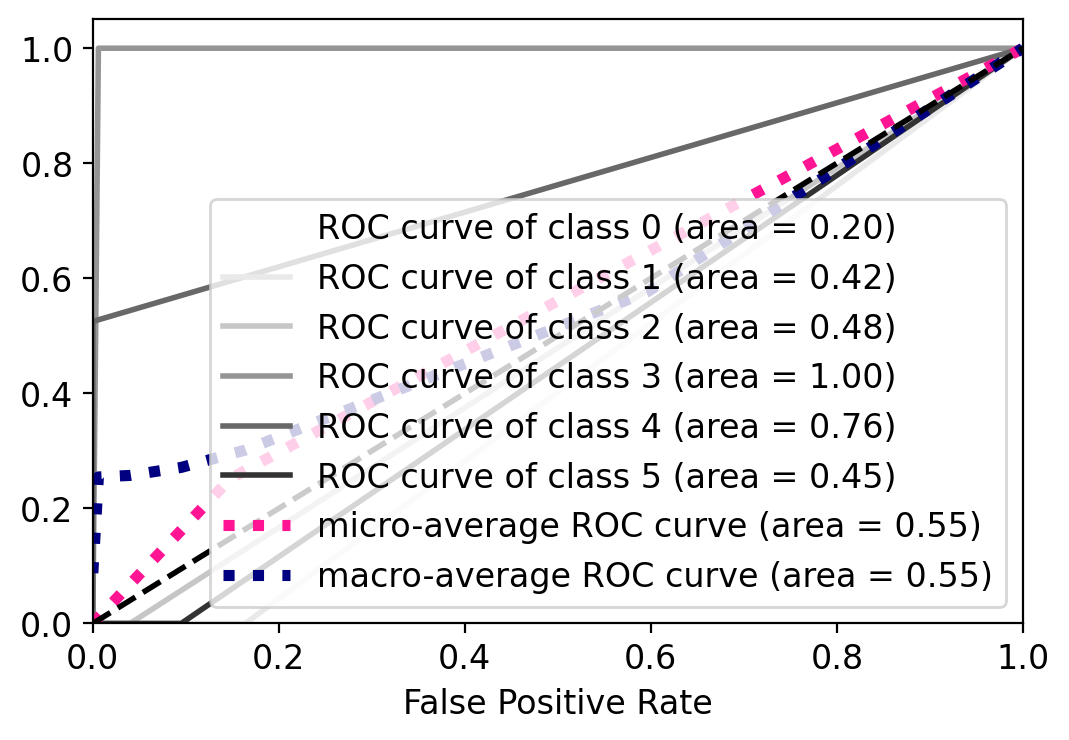

In [28]:
fig_save_path = str(ROOT.joinpath("results", "gmm", "with_unseen_no_aug"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    true_labels,
    predicted_labels,
    predicted_probabilities,
    "",
    save_path=fig_save_path,
)

In [ ]:
batch_size = 240
mfcc_extractor = MFCC(n_mfcc=n_mfcc, hop_length=hop_length)
transforms = Compose([mfcc_extractor])

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...
4800


100%|██████████| 24/24 [02:58<00:00,  7.42s/it]


Predicting: 100%|██████████| 20/20 [00:00<00:00, 240.06it/s]

    F1 Score: 0.39
    Accuracy: 0.39
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

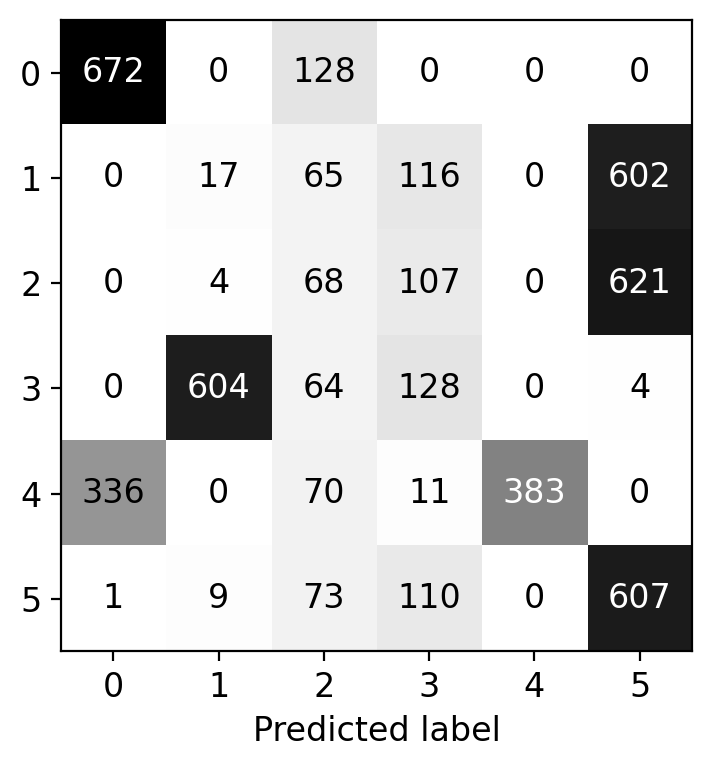

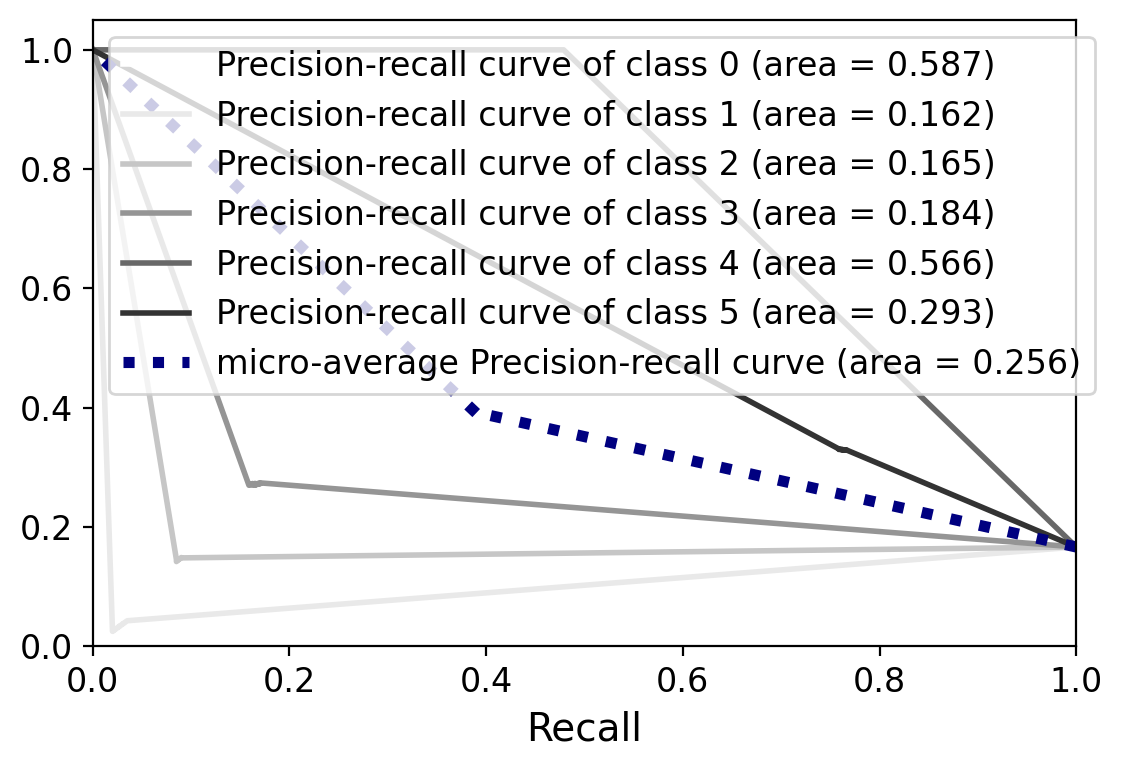

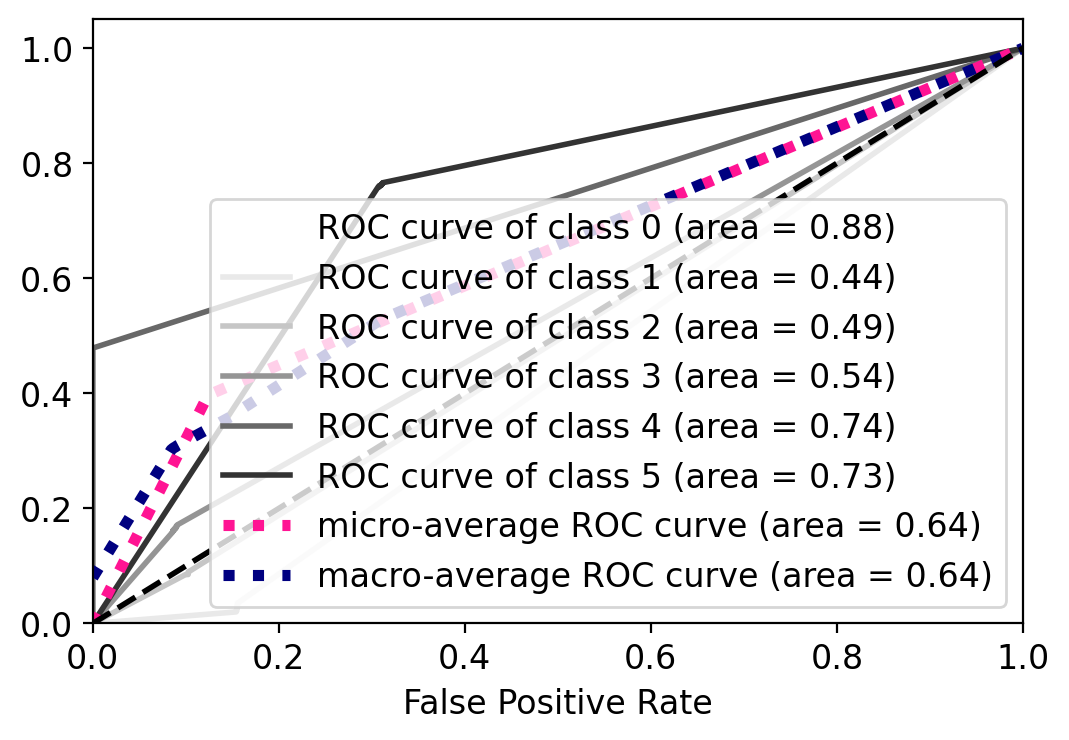

In [29]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_unseen_in_training_data=True,
    should_include_augmented_data=True,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()

print(data_module.num_test_samples)

test_dataloader = data_module.test_dataloader()
X, true_labels = get_numpy_dataset_from_dataloader(test_dataloader, batch_size, return_true_labels=True)

unseen_no_aug_estimator = GaussianMixture.load(
    "/home/iubnlp/spcup22/SPCUP2022/checkpoints/gmm/unseen_aug"
)
predicted_probabilities = unseen_no_aug_estimator.predict_proba(X).detach().numpy()
predicted_labels = np.argmax(predicted_probabilities, axis=1)

print_scores(true_labels, predicted_labels)

fig_save_path = str(ROOT.joinpath("results", "gmm", "with_unseen_aug"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    true_labels,
    predicted_labels,
    predicted_probabilities,
    "",
    save_path=fig_save_path,
)

## CQCC

In [12]:
batch_size = 200
cqcc_extractor = CQCC()
transforms = Compose([cqcc_extractor])

In [13]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_unseen_in_training_data=True,
    should_include_augmented_data=False,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()

print(data_module.num_test_samples)

test_dataloader = data_module.test_dataloader()
X, true_labels = get_numpy_dataset_from_dataloader(test_dataloader, batch_size, return_true_labels=True)

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...
1200


  0%|          | 0/6 [00:00<?, ?it/s]/home/iubnlp/spcup22/SPCUP2022/features/cqcc/CQCC/cqcc.py:176: FutureWarning: Pass orig_sr=1.024, target_sr=9.562 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  Ures_LogP_absCQT = librosa.resample(LogP_absCQT.T, fs, 9.562).T
/home/iubnlp/spcup22/SPCUP2022/features/cqcc/CQCC/cqcc.py:176: FutureWarning: Pass orig_sr=1.024, target_sr=9.562 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  Ures_LogP_absCQT = librosa.resample(LogP_absCQT.T, fs, 9.562).T
/home/iubnlp/spcup22/SPCUP2022/features/cqcc/CQCC/cqcc.py:176: FutureWarning: Pass orig_sr=1.024, target_sr=9.562 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  Ures_LogP_absCQT = librosa.resample(LogP_absCQT.T, fs, 9.562).T
/home/iubnlp/spcup22/SPCUP2022/features/cqcc/CQCC/cqcc.py:176: FutureWarning: Pass orig_sr=1.024, target_sr=9.562 as keyword args. F

/home/iubnlp/anaconda3/envs/spcup/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

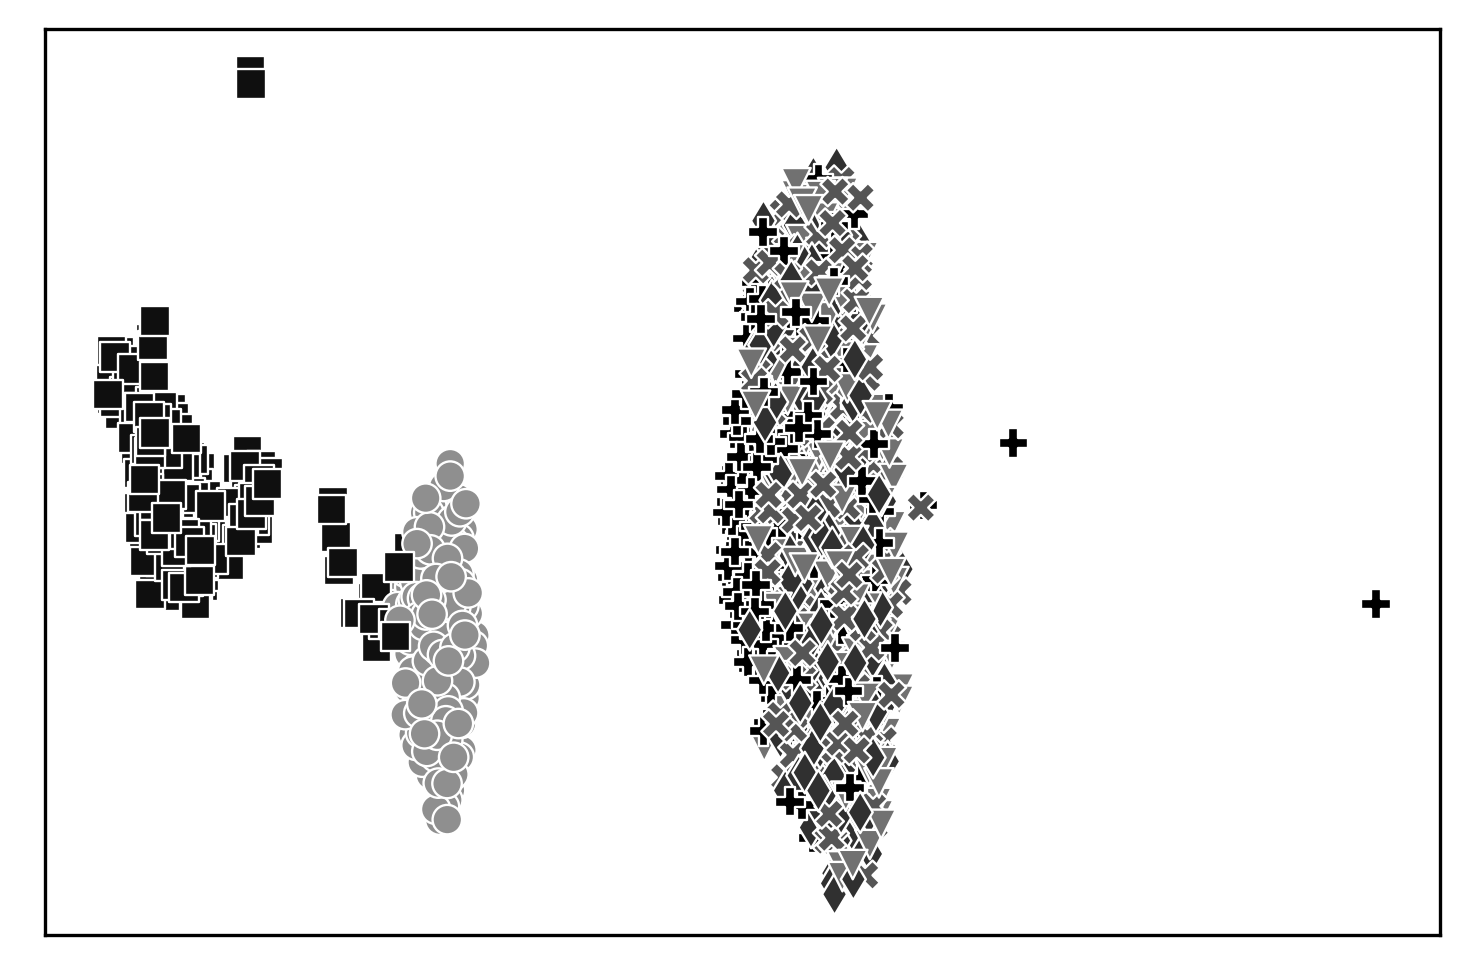

In [14]:
fig, ax = plot_tsne_features(X, true_labels, "")
fig.savefig(
    ROOT.joinpath("results", "cqcc_no_aug.eps"),
    format="eps",
    bbox_inches="tight",
)

Predicting: 100%|██████████| 5/5 [00:00<00:00, 191.35it/s]

    F1 Score: 0.20
    Accuracy: 0.20
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

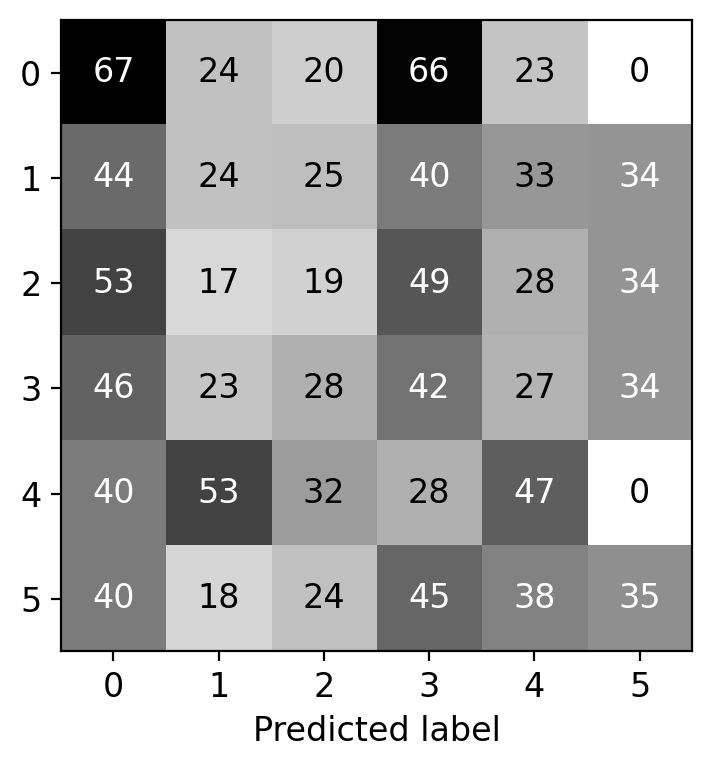

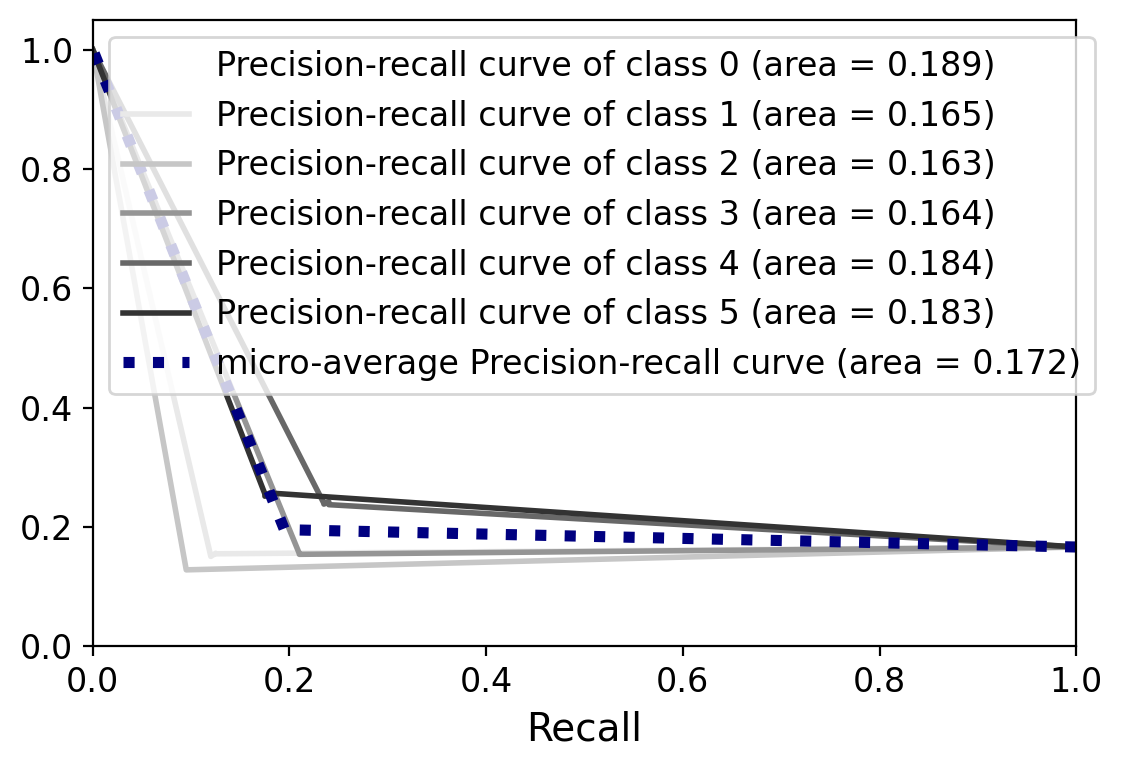

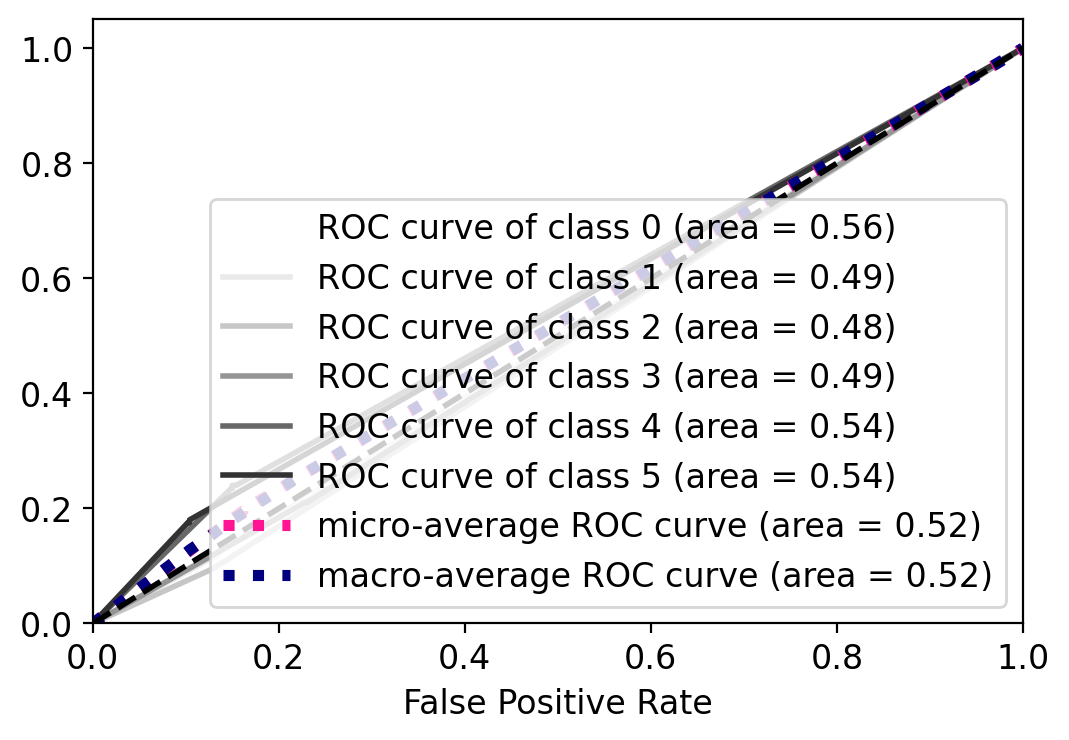

In [15]:
unseen_no_aug_estimator = GaussianMixture.load(
    "/home/iubnlp/spcup22/SPCUP2022/checkpoints/gmm/cqcc_without_aug"
)
predicted_probabilities = unseen_no_aug_estimator.predict_proba(X).detach().numpy()
predicted_labels = np.argmax(predicted_probabilities, axis=1)

print_scores(true_labels, predicted_labels)

fig_save_path = str(ROOT.joinpath("results", "gmm", "cqcc_with_unseen_no_aug"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    true_labels,
    predicted_labels,
    predicted_probabilities,
    "",
    save_path=fig_save_path,
)

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

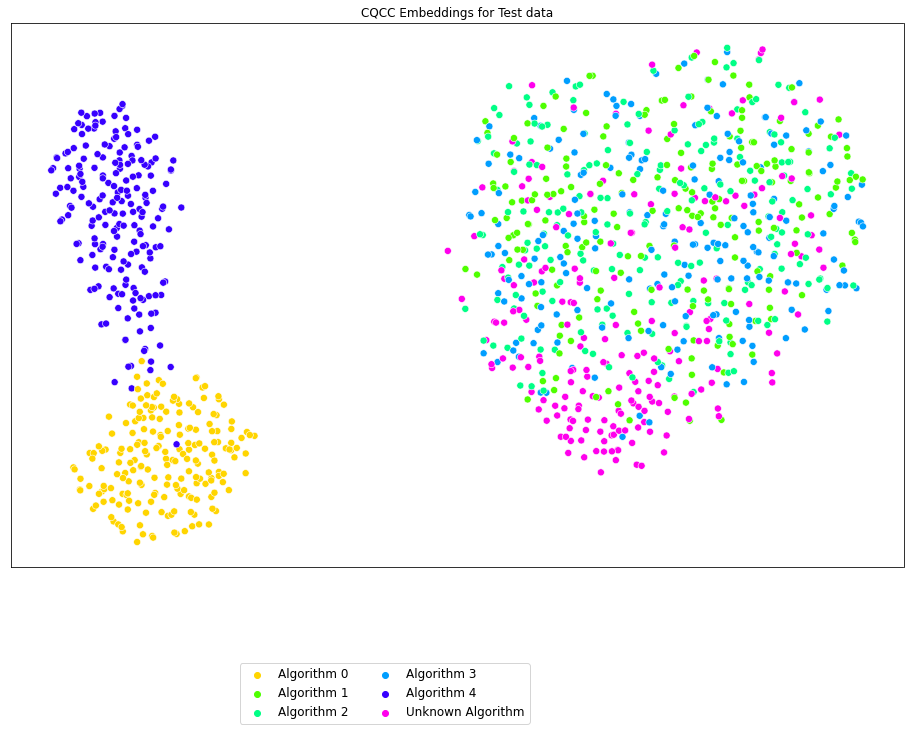

In [30]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_pca)

plt.figure(figsize=(16, 10))
graph = sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=true_labels,
    palette=sns.color_palette("hsv", len(np.unique(true_labels))),
    s=50,
    alpha=1.0,
    rasterized=True, 

)
plt.xticks([], [])
plt.yticks([], [])
plt.title("CQCC Embeddings for Test data")


plt.legend(loc='lower left', bbox_to_anchor=(0.25, -0.3), ncol=2)
legend = graph.legend_
for j, (actual_label, label) in enumerate(zip(np.unique(true_labels), np.unique(true_labels))):
    if label == 5:
        legend.get_texts()[j].set_text(f"Unknown Algorithm") 
    else:
        legend.get_texts()[j].set_text(f"Algorithm {label}") 

In [19]:
batch_size = 240
cqcc_extractor = CQCC()
transforms = Compose([cqcc_extractor])

In [20]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_unseen_in_training_data=True,
    should_include_augmented_data=True,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()

print(data_module.num_test_samples)

test_dataloader = data_module.test_dataloader()
X, true_labels = get_numpy_dataset_from_dataloader(test_dataloader, batch_size, return_true_labels=True)

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...
4800


  0%|          | 0/20 [00:00<?, ?it/s]/home/iubnlp/spcup22/SPCUP2022/features/cqcc/CQCC/cqcc.py:176: FutureWarning: Pass orig_sr=1.024, target_sr=9.562 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  Ures_LogP_absCQT = librosa.resample(LogP_absCQT.T, fs, 9.562).T
/home/iubnlp/spcup22/SPCUP2022/features/cqcc/CQCC/cqcc.py:176: FutureWarning: Pass orig_sr=1.024, target_sr=9.562 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  Ures_LogP_absCQT = librosa.resample(LogP_absCQT.T, fs, 9.562).T
/home/iubnlp/spcup22/SPCUP2022/features/cqcc/CQCC/cqcc.py:176: FutureWarning: Pass orig_sr=1.024, target_sr=9.562 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  Ures_LogP_absCQT = librosa.resample(LogP_absCQT.T, fs, 9.562).T
/home/iubnlp/spcup22/SPCUP2022/features/cqcc/CQCC/cqcc.py:176: FutureWarning: Pass orig_sr=1.024, target_sr=9.562 as keyword args. 

Predicting: 100%|██████████| 20/20 [00:00<00:00, 235.75it/s]

    F1 Score: 0.16
    Accuracy: 0.16
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

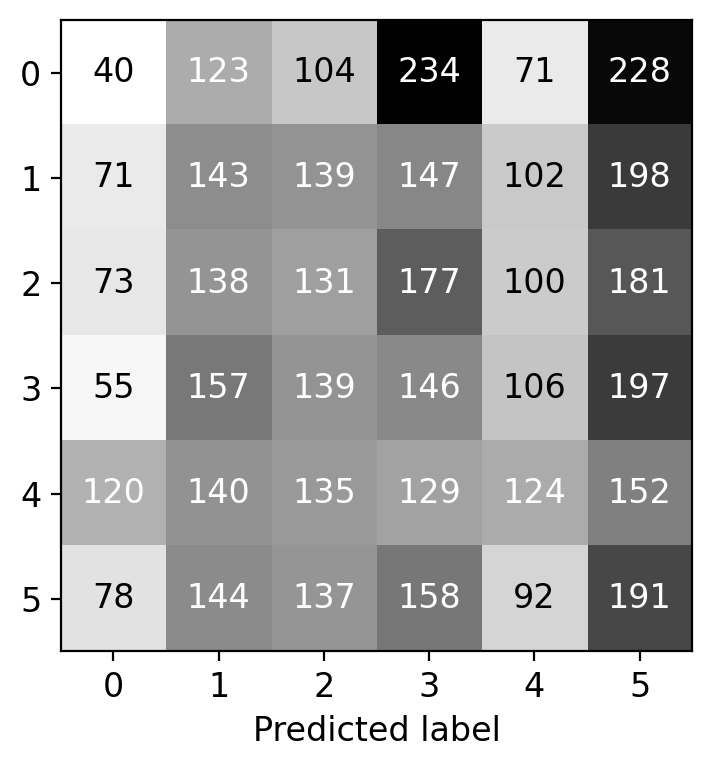

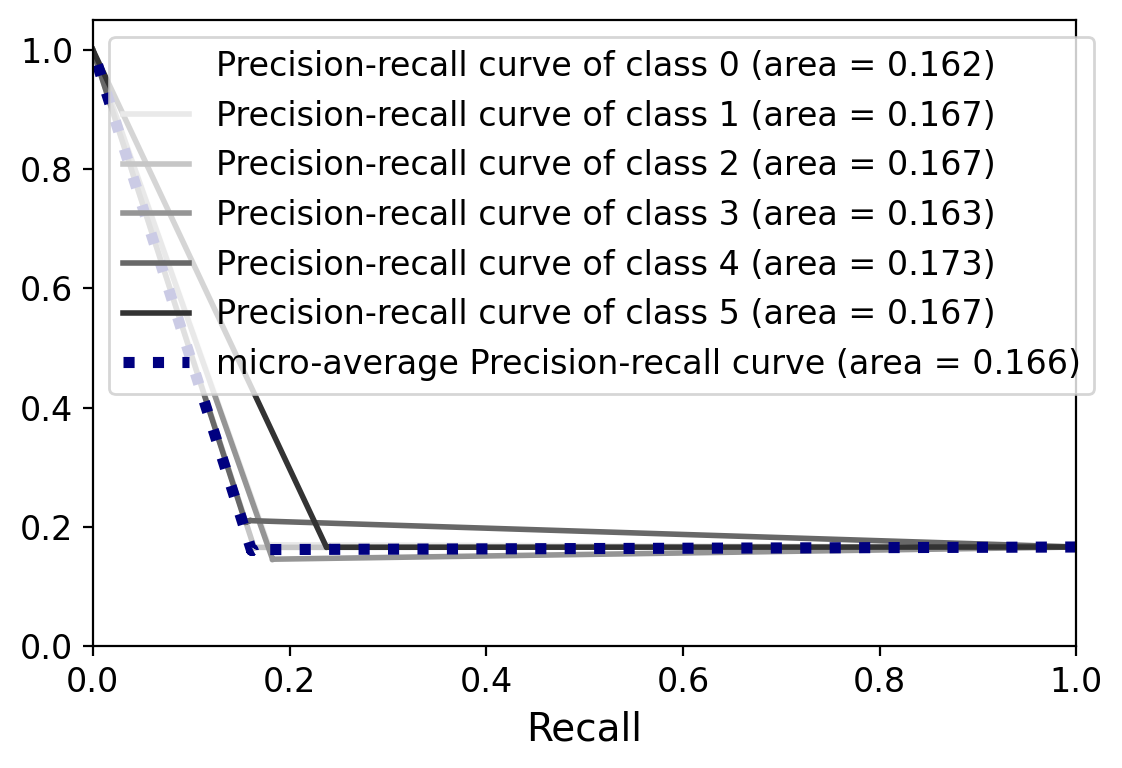

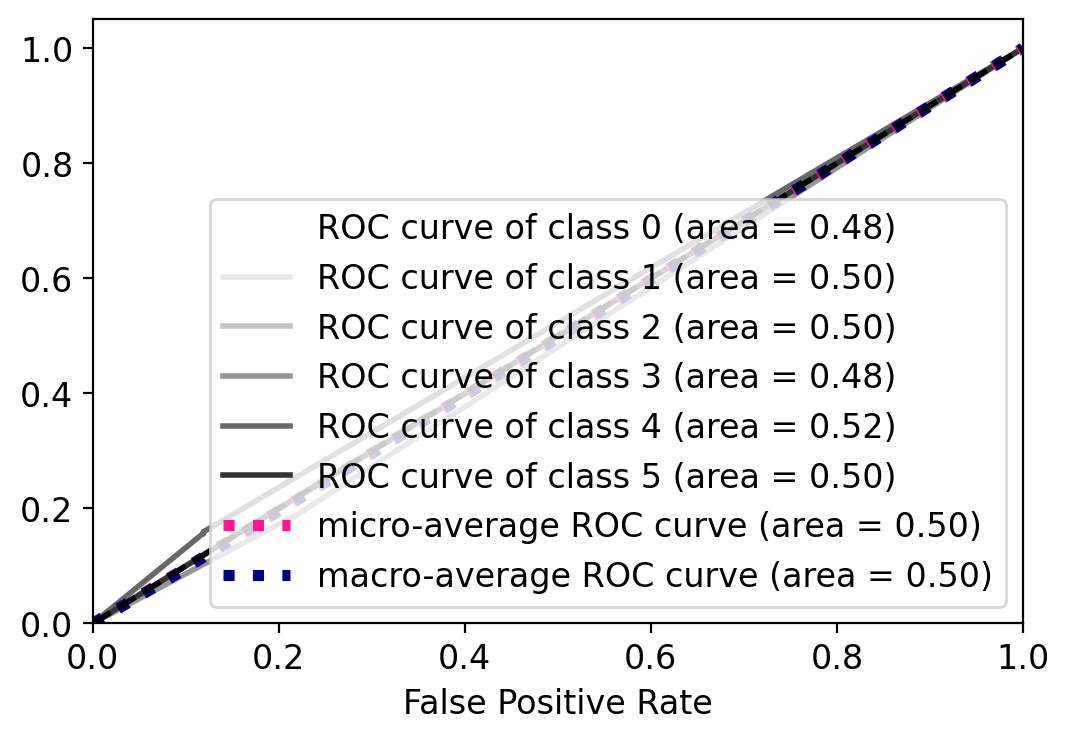

In [21]:
unseen_aug_estimator = GaussianMixture.load(
    "/home/iubnlp/spcup22/SPCUP2022/checkpoints/gmm/cqcc_with_aug"
)
predicted_probabilities = unseen_aug_estimator.predict_proba(X).detach().numpy()
predicted_labels = np.argmax(predicted_probabilities, axis=1)

print_scores(true_labels, predicted_labels)

fig_save_path = str(ROOT.joinpath("results", "gmm", "cqcc_with_unseen_aug"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    true_labels,
    predicted_labels,
    predicted_probabilities,
    "",
    save_path=fig_save_path,
)

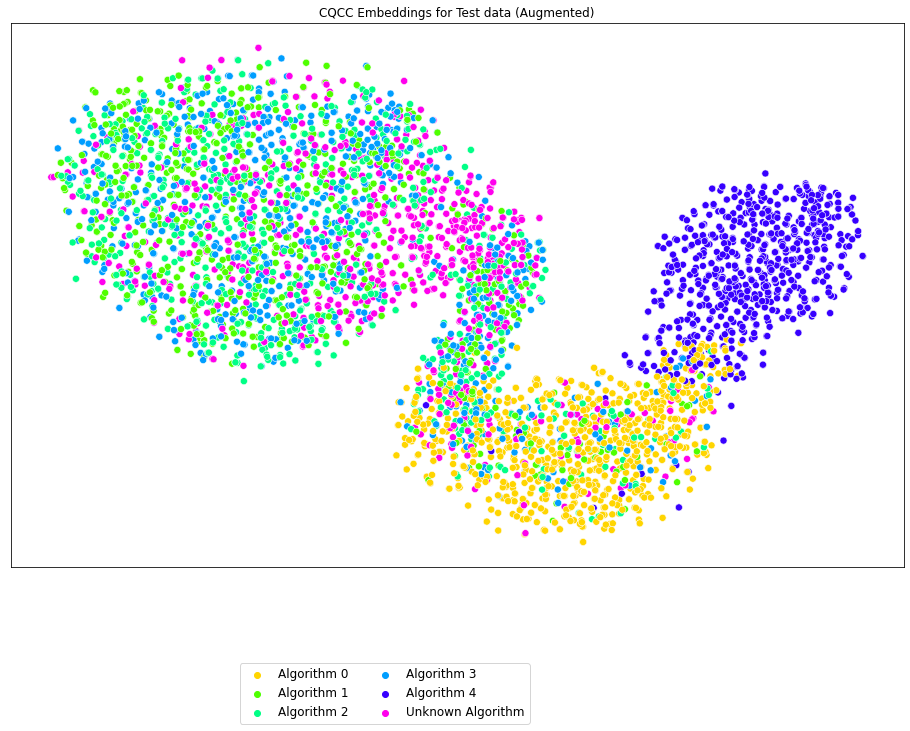

In [22]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_pca)

plt.figure(figsize=(16, 10))
graph = sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=true_labels,
    palette=sns.color_palette("hsv", len(np.unique(true_labels))),
    s=50,
    alpha=1.0,
    rasterized=True, 

)
plt.xticks([], [])
plt.yticks([], [])
plt.title("CQCC Embeddings for Test data (Augmented)")


plt.legend(loc='lower left', bbox_to_anchor=(0.25, -0.3), ncol=2)
legend = graph.legend_
for j, (actual_label, label) in enumerate(zip(np.unique(true_labels), np.unique(true_labels))):
    if label == 5:
        legend.get_texts()[j].set_text(f"Unknown Algorithm") 
    else:
        legend.get_texts()[j].set_text(f"Algorithm {label}") 

In [8]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_unseen_in_training_data=True,
    should_include_augmented_data=True,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...


In [9]:
test_dataloader = data_module.test_dataloader()
X, true_labels = get_numpy_dataset_from_dataloader(
    test_dataloader, batch_size, return_true_labels=True
)

100%|██████████| 6/6 [00:44<00:00,  7.44s/it]


In [12]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

In [17]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_pca)

In [18]:
X_embedded.shape

(1200, 2)

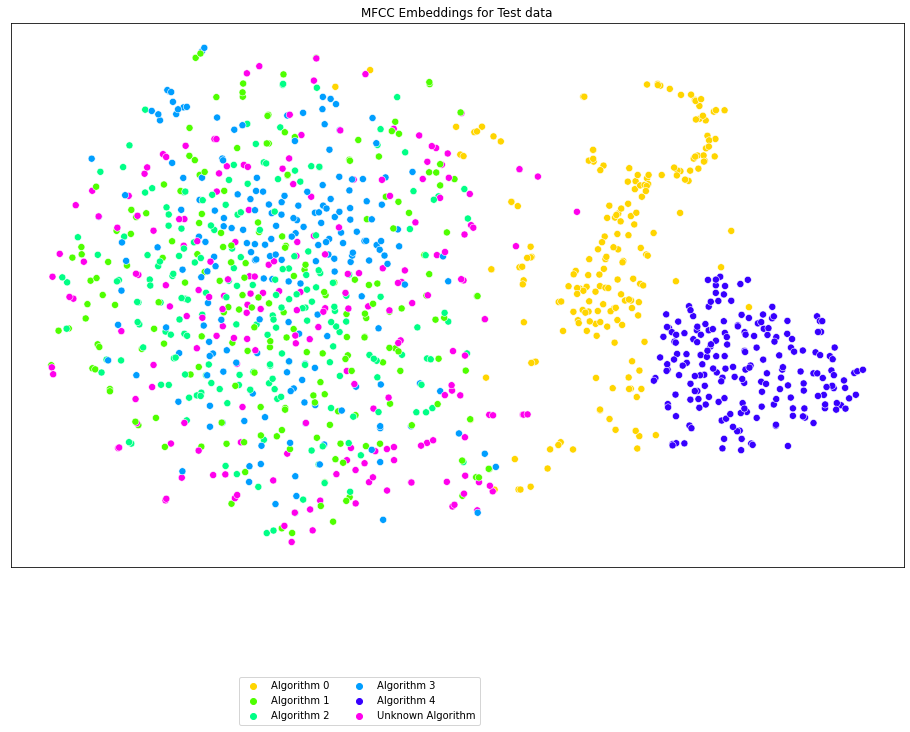